<a href="https://colab.research.google.com/github/kirill-kozlitin/test_tasks/blob/main/test_hr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

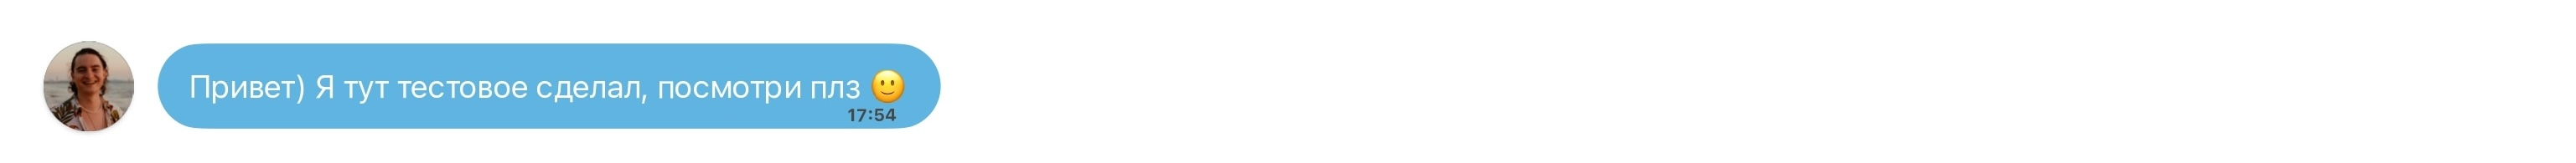

In [1]:
# Подключение к облачному хранилищу
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy.stats as stats
import warnings


pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/Тестовые/Тестовое Альфа/'
sys.path.append(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Данные
df = pd.read_excel(path + 'тестовое 202309.xlsx')

## Анализ выборки и предобработка

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1730 entries, 0 to 1729
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Дата                                       1730 non-null   datetime64[ns]
 1   пп                                         1730 non-null   int64         
 2   % выполнения KPI в первые 3 месяца работы  1730 non-null   float64       
 3   % выполнения KPI в 4-6 месяцы работы       1307 non-null   float64       
 4   Итоговый балл                              1730 non-null   int64         
 5   блок_1_1                                   1502 non-null   float64       
 6   блок_1_2                                   1730 non-null   int64         
 7   блок_1_3                                   1502 non-null   float64       
 8   блок_1_4                                   1730 non-null   int64         
 9   блок_1_5           

- В данных есть пропуски
- Блоки 4 и 5 имеют совсем мало данных
- Данные предположительно содержат скрытый таргет. % выполнения KPI в 4-6 месяц работы имеет порядка 400 пропусков. Есть предположение, что часть из этих пропусков - это новые сотрудники, а другая часть - те, кто уволился роработав менее 4 месяцев.

Проанализируем ситуацию с увольнением. Есть ощущение что это может быть полезно.

Предположение: в качестве уволившихся будем считать тех сотрудников, у кого в поле KPI за 4-6 мес. работы стоит пропуск, и в то же время дата тестирования раньше на 4 и более месяцев чем самая поздняя дата в выборке.

Но прежде чем проставлять отметки об увольнении, сравним тех, кто предположительно проработал менее 4 мес., с теми, кто проработал более 6 мес. Построим гистограммы распределения для той и другой группы:

In [5]:
last_date = df['Дата'].max()

df_prob_fired = df.loc[(df['% выполнения KPI в 4-6 месяцы работы'].isna()) & ((last_date - df['Дата']).dt.days > 3*30)]
df_prob_new = df.loc[(df['% выполнения KPI в 4-6 месяцы работы'].isna()) & ((last_date - df['Дата']).dt.days <= 3*30)]
df_work_gr6 = df.loc[~df['% выполнения KPI в 4-6 месяцы работы'].isna()]

print('Предположительно уволившиеся, кол-во:', df_prob_fired.shape[0])
print('Предположительно новенькие, кол-во:', df_prob_new.shape[0])
print('Работающие более 6 мес., кол-во:', df_work_gr6.shape[0])

Предположительно уволившиеся, кол-во: 419
Предположительно новенькие, кол-во: 4
Работающие более 6 мес., кол-во: 1307


Предположительно новеньких очень мало. Менее 1%. На различия в распределении они не должны повлиять. Поэтому далее можно считать всех у кого пропусти в KPI 4-6 мес. одной группой.

Сравним ее с группой тех, кто проработал более 6 мес.

In [6]:
df_prob_fired = df.loc[(df['% выполнения KPI в 4-6 месяцы работы'].isna())] # добавляем новеньких чтобы их не потерять

In [7]:
scores = list(df.drop(['пп', 'Дата'], axis='columns').columns)
# scores

Строим распределения:

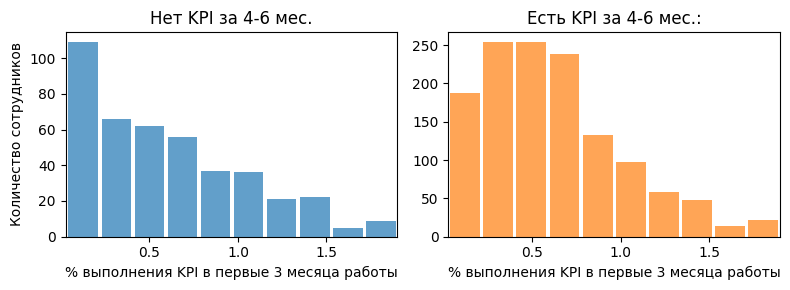

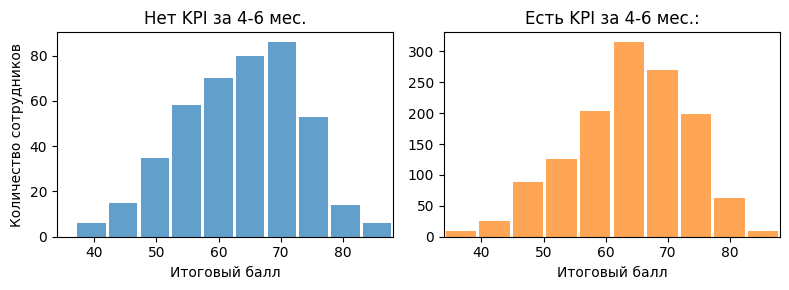

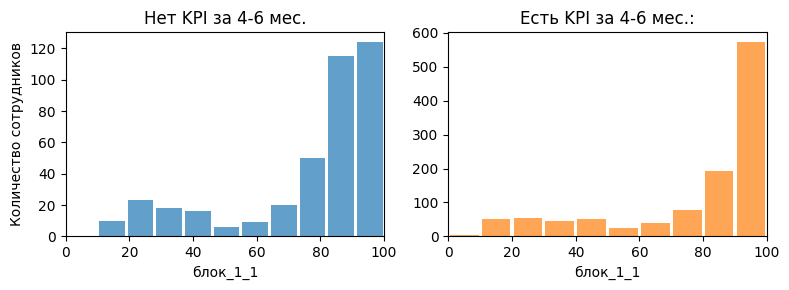

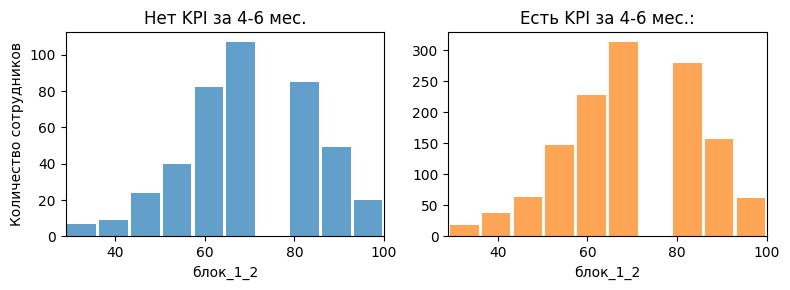

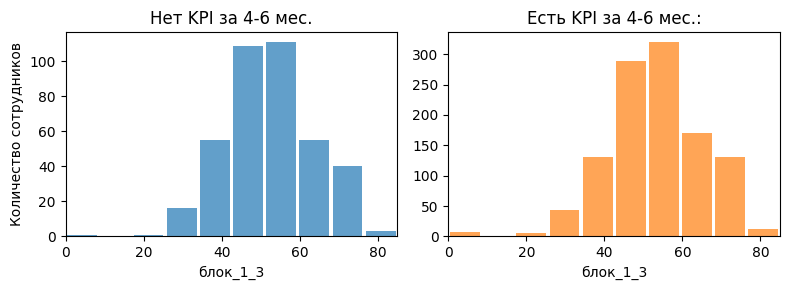

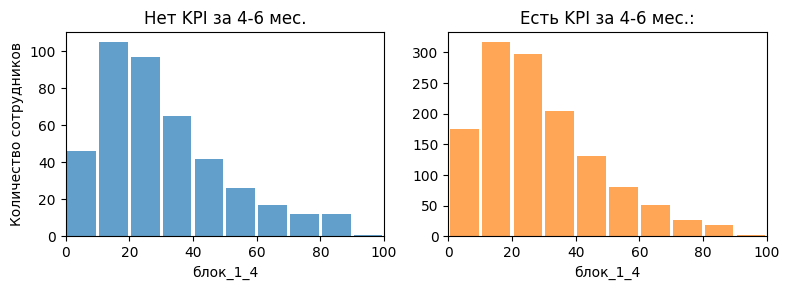

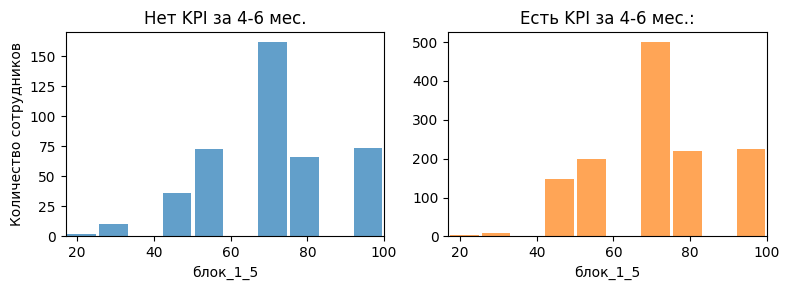

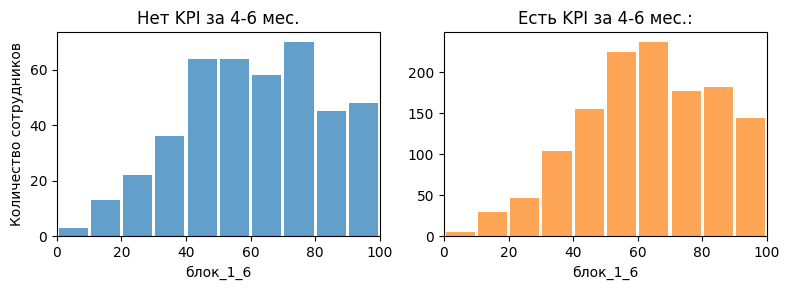

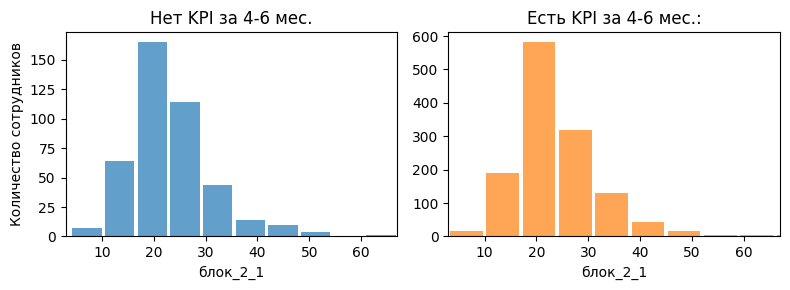

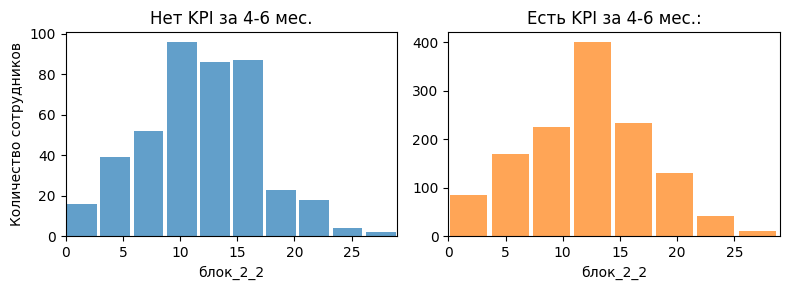

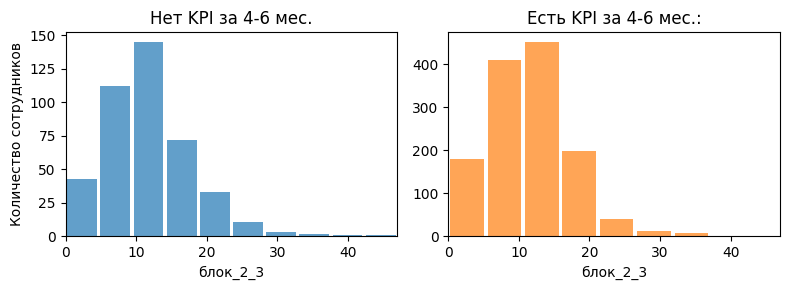

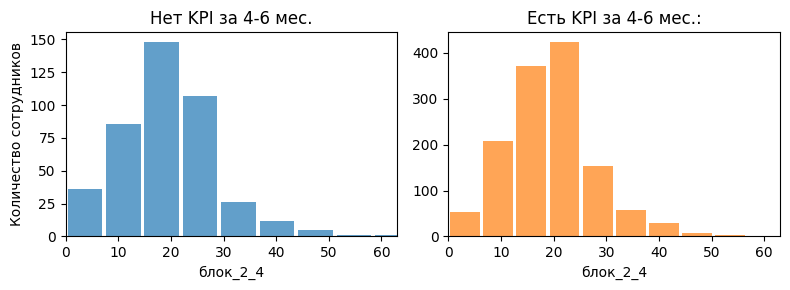

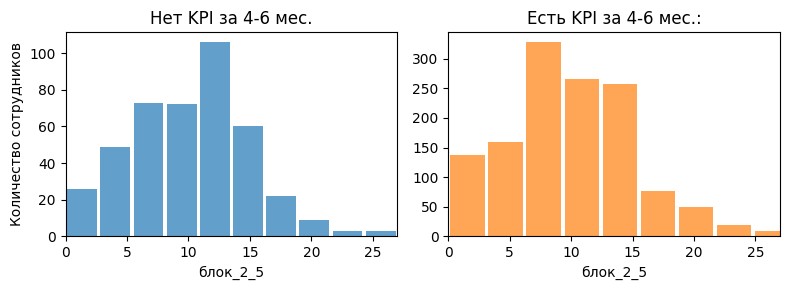

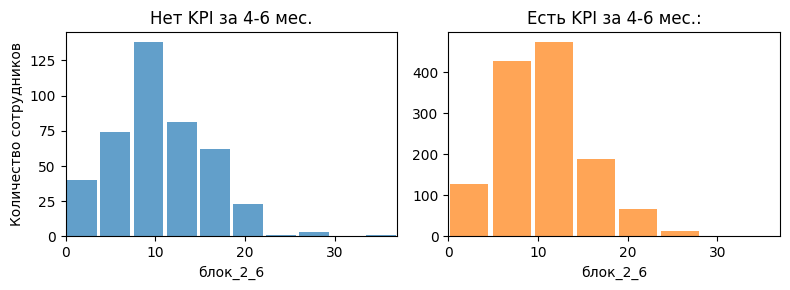

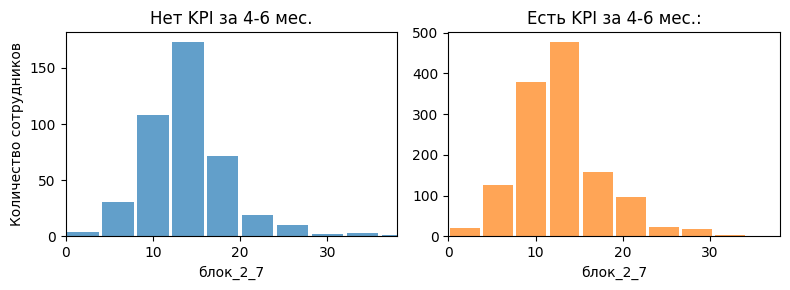

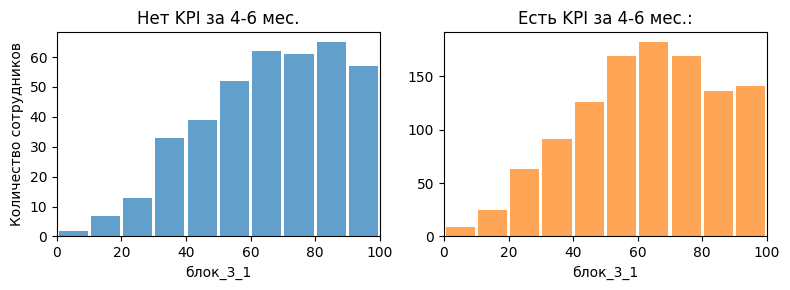

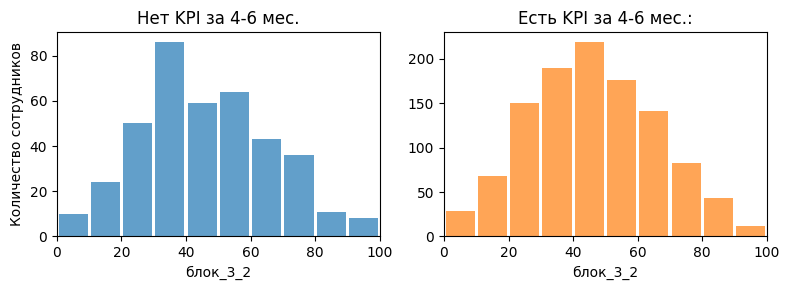

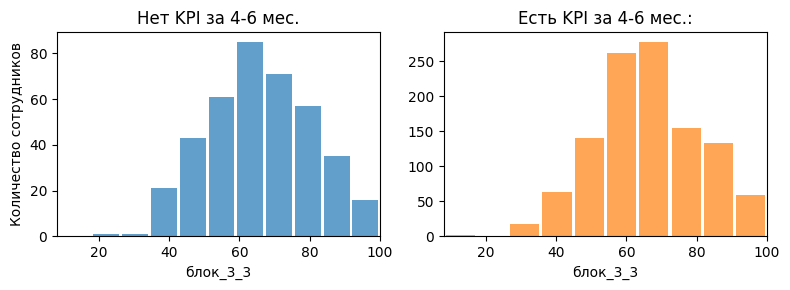

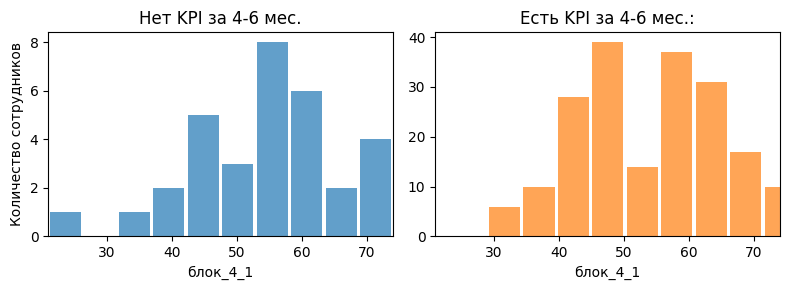

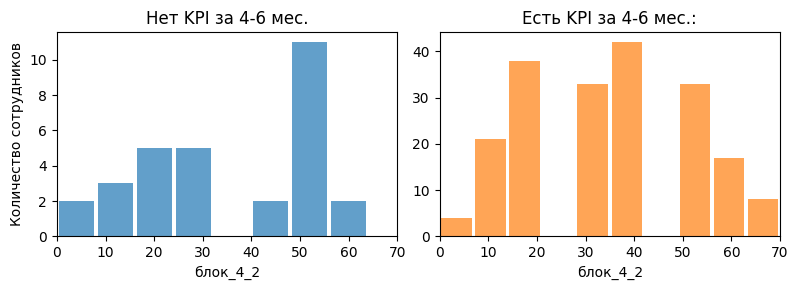

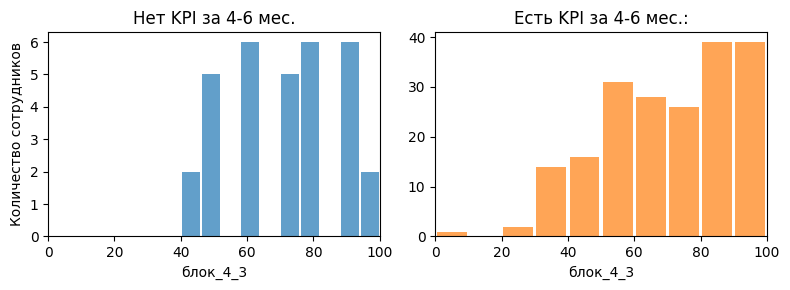

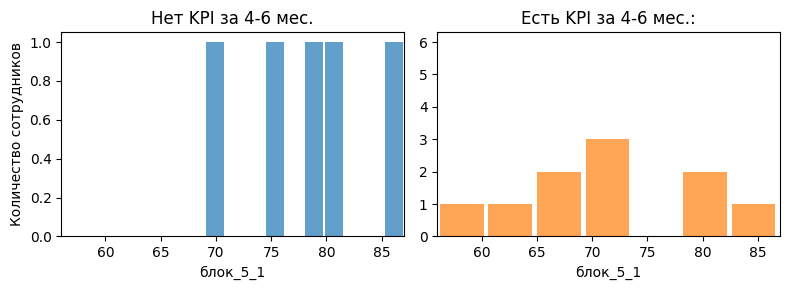

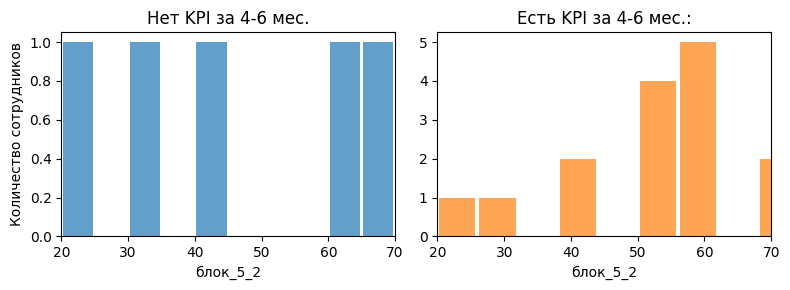

In [8]:
for score in scores:

  if score == '% выполнения KPI в 4-6 месяцы работы':
    continue

  min_x = min(df_work_gr6[score].min(), df_prob_fired[score].min())
  max_x = min(df_work_gr6[score].max(), df_prob_fired[score].max())

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

  # Гистограмма Нет KPI за 4-6 мес
  axes[0].hist(df_prob_fired[score], color='#1f77b4', rwidth=0.9, alpha=0.7)
  axes[0].set_title(f'Нет KPI за 4-6 мес.')
  axes[0].set_ylabel('Количество сотрудников')
  axes[0].set_xlabel(score)
  axes[0].set_xlim(min_x, max_x)

  # Гистограмма Есть KPI за 4-6 мес
  axes[1].hist(df_work_gr6[score], color='#ff7f0e', rwidth=0.9, alpha=0.7)
  axes[1].set_title(f'Есть KPI за 4-6 мес.:')
  axes[1].set_xlabel(score)
  axes[1].set_xlim(min_x, max_x)

  plt.tight_layout()  # автоматическая корректировка подложек, чтобы они не перекрывались
  plt.show()


Визуально различия заметны только для Итогового балла, и 3-мес. KPI. Сотрудники без KPI за 4-6 мес. чуть хуже в среднем сдавали тесты и получали в среднем более низний 3-мес. KPI.

Отметим предположительно уволенных в нашей выборке:

In [9]:
df['cogorta_fired'] = df['% выполнения KPI в 4-6 месяцы работы'].apply(lambda x: 1 if pd.isna(x) else 0)
print('Количество отметок:', df['cogorta_fired'].sum())

Количество отметок: 423


Названия колонок с KPI слишком длинные. Создадим словарь с их короткими версиями:

In [10]:
short_name_dct = {
      'Итоговый балл':'ИБ',
      '% выполнения KPI в первые 3 месяца работы':'KPI_3',
      '% выполнения KPI в 4-6 месяцы работы':'KPI_4_6',
  }


## Задания

### Задание 1.1

**Построить помесячную динамику итогового балла и динамику выполнения KPI**

Сагрегируем данные помесячно функциями среднего, максимума, минимума, медианы.

Для этого, сначала приведем даты к первому числу каждого месяца:

In [11]:
df['Дата мес.'] = pd.to_datetime(df['Дата'].dt.strftime('%Y-%m-01'))

Теперь строим графики помесячной динамики:

In [12]:
# Функция для отрисовки графиков динамики
def plot_score_dynamics(df, score):

    # группировка таблицы помесячно
    monthly_aggregated_data = df.groupby('Дата мес.', as_index=False)[score].agg({ 'min':min,
                                                                 'max':max,
                                                                 'mean':'mean',
                                                                 'median':'median'})

    # сортируем данные по дате (от старых к новым)
    monthly_aggregated_data = monthly_aggregated_data.sort_values('Дата мес.', ascending=False)

    # Для KPI агрегированные значения умножаем на 100 для приведения к процентам
    if score in ['% выполнения KPI в первые 3 месяца работы', '% выполнения KPI в 4-6 месяцы работы']:
        monthly_aggregated_data.iloc[:, 1:] = monthly_aggregated_data.iloc[:, 1:] * 100

    # строим графики динамики
    sns.set_style("darkgrid")
    palette = plt.get_cmap('Set1')
    plt.figure(figsize=(10, 4))

    # Заполняем область между min и max
    plt.fill_between(monthly_aggregated_data['Дата мес.'],
                     monthly_aggregated_data['min'],
                     monthly_aggregated_data['max'],
                     color='grey',
                     alpha=0.1,
                     label="Range min-max")

    plt.plot(monthly_aggregated_data['Дата мес.'], monthly_aggregated_data['mean'], marker='', color=palette(0), linewidth=1.5, label="mean")
    plt.plot(monthly_aggregated_data['Дата мес.'], monthly_aggregated_data['max'], marker='', color=palette(1), linewidth=1.5, label="max")
    plt.plot(monthly_aggregated_data['Дата мес.'], monthly_aggregated_data['min'], marker='', color=palette(2), linewidth=1.5, label="min")
    plt.plot(monthly_aggregated_data['Дата мес.'], monthly_aggregated_data['median'], marker='', color=palette(3), linewidth=1.5, label="median")

    # Добавляем заголовок и подписи к осям
    plt.title(f"Динамика {score} по месяцам", loc='left', fontsize=12, fontweight=0,)
    plt.xlabel("Дата")
    plt.ylabel(score)

    # Добавляем легенду
    plt.legend(loc='upper center', ncol=len(monthly_aggregated_data.columns)-1, bbox_to_anchor=(0.5, 1))
    plt.grid(True)

    # Поворачиваем подписи к оси X
    plt.xticks(rotation=45)
    plt.ylim(monthly_aggregated_data['min'].min() - monthly_aggregated_data['min'].min()*0.25,
             monthly_aggregated_data['max'].max() + monthly_aggregated_data['max'].min()*0.25,)

    # Отображаем график
    plt.tight_layout()
    plt.show()

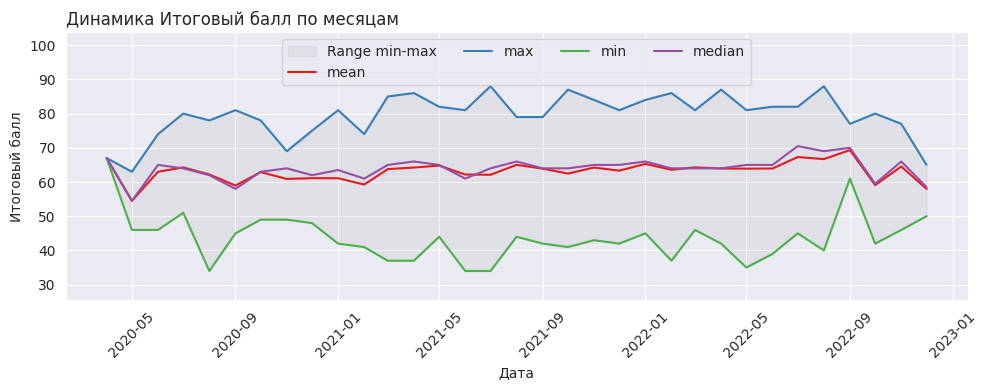

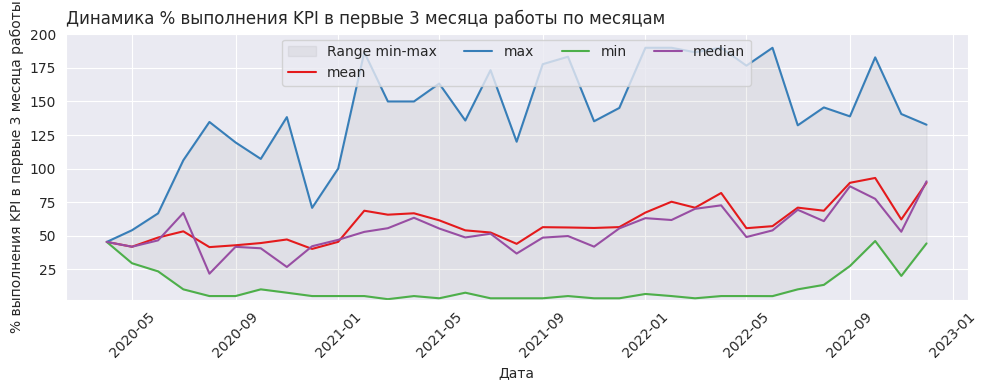

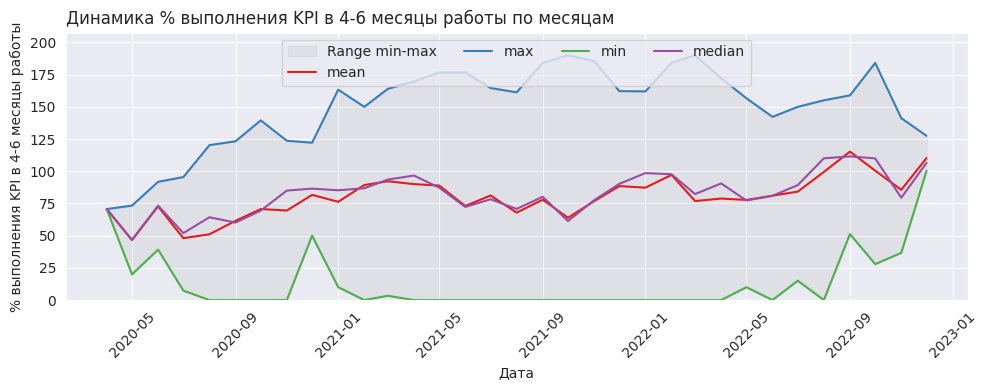

In [13]:
for score in ['Итоговый балл', '% выполнения KPI в первые 3 месяца работы', '% выполнения KPI в 4-6 месяцы работы']:
    plot_score_dynamics(df, score)

Наблюдения:
- Динамика итогового балла равномерная. Есть несколько зеркальных участков для минимума и максимума
- Динамика 3-мес. KPI позитивная. Средний показатель KPI растет.
- Динамика 4-6-мес. KPI аналогична 3-мес. KPI.

### Задание 1.2

**Посчитать для сотрудников отклонение от среднемесячного по банку. Посчитайте разные виды отклонений.**

Отклонения по итоговому баллу и KPI для каждого сотрудника будем считать в таких разрезах:
- от среднемесячного результата
- от общего среднего результата
- от кумулятивного среднего до даты тестирования
- от результата предыдущего сотрудника
- от среднего результата по группе (проведем кластеризацию)

Отклонения от медианы, минимума, максимума считать не будем, ограничимся средним. Помимо этого опустим и отностельные величины, чтобы не нагружать таблицу.

In [14]:
# Создаем новый локальный датафрейм
df_pers = df[['пп',
              'Дата мес.',
              '% выполнения KPI в первые 3 месяца работы',
              '% выполнения KPI в 4-6 месяцы работы',
              'Итоговый балл'
]].copy()

Расчитаем **среднемесячные значения**:

In [15]:
# Группируем и агрегируем средним
df_avg_month =  df_pers.groupby('Дата мес.', as_index=False)[['% выполнения KPI в первые 3 месяца работы',
                                                           '% выполнения KPI в 4-6 месяцы работы',
                                                           'Итоговый балл']].mean()
# Переименовываем колонки
df_avg_month.rename({key: item + '_avg_mnth' for key, item in short_name_dct.items()}, axis='columns', inplace=True)

df_avg_month.head()

,Дата мес.,KPI_3_avg_mnth,KPI_4_6_avg_mnth,ИБ_avg_mnth
0,2020-04-01,0.45,0.71,67.00
1,2020-05-01,0.42,0.47,54.50
2,2020-06-01,0.49,0.73,63.00
3,2020-07-01,0.53,0.48,64.27
4,2020-08-01,0.41,0.51,62.21


Корректность расчетов проверил за пределами тетрадки.



Теперь расчитаем **куммулятивное среднее**. Это может быть полезной фичей при оценке отклонения с учетом историчности.

In [16]:
# Группируем данные помесячно. Агрегируем суммой и количеством
df_cum_avg_month = df_pers.groupby('Дата мес.', as_index=False).agg({
                        '% выполнения KPI в первые 3 месяца работы': [sum, 'count'],
                        '% выполнения KPI в 4-6 месяцы работы': [sum, 'count'],
                        'Итоговый балл': [sum, 'count']
})

# Сбрасываем мультииндекс и переименовываем
df_cum_avg_month.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_cum_avg_month.columns.values]

# Расчитываем куммулятивные средние
df_cum_avg_month['ИБ_cum_avg_mnth'] = df_cum_avg_month['Итоговый балл_sum'].cumsum() /\
                                      df_cum_avg_month['Итоговый балл_count'].cumsum()

df_cum_avg_month['KPI_3_cum_avg_mnth'] = df_cum_avg_month['% выполнения KPI в первые 3 месяца работы_sum'].cumsum() /\
                                         df_cum_avg_month['% выполнения KPI в первые 3 месяца работы_count'].cumsum()

df_cum_avg_month['KPI_4_6_cum_avg_mnth'] = df_cum_avg_month['% выполнения KPI в 4-6 месяцы работы_sum'].cumsum() /\
                                           df_cum_avg_month['% выполнения KPI в 4-6 месяцы работы_count'].cumsum()

# Фильтруем колонки датафрейма
df_cum_avg_month = df_cum_avg_month[['Дата мес.',
                                     'ИБ_cum_avg_mnth',
                                     'KPI_3_cum_avg_mnth',
                                     'KPI_4_6_cum_avg_mnth']]

Теперь объединим расчитанные средние с нашей выборкой с сотрудниками:

In [17]:
df_pers = df_pers.merge(df_avg_month, on=['Дата мес.'])
df_pers = df_pers.merge(df_cum_avg_month, on=['Дата мес.'])

In [18]:
df_pers.head()

,пп,Дата мес.,% выполнения KPI в первые 3 месяца работы,% выполнения KPI в 4-6 месяцы работы,Итоговый балл,KPI_3_avg_mnth,KPI_4_6_avg_mnth,ИБ_avg_mnth,ИБ_cum_avg_mnth,KPI_3_cum_avg_mnth,KPI_4_6_cum_avg_mnth
0,1,2020-05-01,0.54,0.73,63,0.42,0.47,54.50,58.67,0.43,0.55
1,32,2020-05-01,0.29,0.20,46,0.42,0.47,54.50,58.67,0.43,0.55
2,2,2022-06-01,0.30,0.41,66,0.57,0.81,63.95,63.61,0.61,0.80
3,10,2022-06-01,0.94,NaN,47,0.57,0.81,63.95,63.61,0.61,0.80
4,15,2022-06-01,0.77,0.42,67,0.57,0.81,63.95,63.61,0.61,0.80


**Расчет отклонений**:

In [19]:
for score, short_name in short_name_dct.items():

  # статистики по всей выборке
  mean = df_pers[score].mean()
  median = df_pers[score].median()
  std = df_pers[score].std()

  # отклонения от среднемесячного результата
  df_pers[f'{short_name}. Отклонение от среднемес., абс.'] = df_pers[score] - df_pers[f'{short_name}_avg_mnth']
  df_pers[f'{short_name}. Отклонение от среднемес., %'] = ((df_pers[score] - df_pers[f'{short_name}_avg_mnth']) / df_pers[f'{short_name}_avg_mnth']) * 100

  # отклонения от общего среднего результата
  df_pers[f'{short_name}. Отклонение от среднего, абс.'] = df_pers[score] - mean
  df_pers[f'{short_name}. Отклонение от среднего, %'] = ((df_pers[score] - mean) / mean) * 100

  # отклонения от куммулятивного среднего результата
  df_pers[f'{short_name}. Отклонение от кумм. среднего, абс.'] = df_pers[score] - df_pers[f'{short_name}_cum_avg_mnth']
  df_pers[f'{short_name}. Отклонение от кумм. среднего, %'] = ((df_pers[score] - df_pers[f'{short_name}_cum_avg_mnth']) / df_pers[f'{short_name}_cum_avg_mnth']) * 100

  # отклонения от медианного результата
  df_pers[f'{short_name}. Отклонение от медианы, абс.'] = df_pers[score] - median
  df_pers[f'{short_name}. Отклонение от медианы, %.'] = ((df_pers[score] - median) / median) * 100

  # флаг об отклонении от среднего результата более чем на 1 стандартное отклонение
  df_pers[f'{short_name}. Отклонение от среднего больше стандартного'] = df_pers[f'{short_name}. Отклонение от среднего, %'].apply(lambda x: 1 if x > std else 0)

df_pers

,пп,Дата мес.,% выполнения KPI в первые 3 месяца работы,% выполнения KPI в 4-6 месяцы работы,Итоговый балл,KPI_3_avg_mnth,KPI_4_6_avg_mnth,ИБ_avg_mnth,ИБ_cum_avg_mnth,KPI_3_cum_avg_mnth,...,KPI_3. Отклонение от среднего больше стандартного,"KPI_4_6. Отклонение от среднемес., абс.","KPI_4_6. Отклонение от среднемес., %","KPI_4_6. Отклонение от среднего, абс.","KPI_4_6. Отклонение от среднего, %","KPI_4_6. Отклонение от кумм. среднего, абс.","KPI_4_6. Отклонение от кумм. среднего, %","KPI_4_6. Отклонение от медианы, абс.","KPI_4_6. Отклонение от медианы, %.",KPI_4_6. Отклонение от среднего больше стандартного
0,1,2020-05-01,0.54,0.73,63,0.42,0.47,54.50,58.67,0.43,...,0,0.27,57.28,-0.08,-9.37,0.19,34.25,-0.09,-11.08,0
1,32,2020-05-01,0.29,0.20,46,0.42,0.47,54.50,58.67,0.43,...,0,-0.27,-57.28,-0.61,-75.39,-0.35,-63.54,-0.63,-75.85,0
2,2,2022-06-01,0.30,0.41,66,0.57,0.81,63.95,63.61,0.61,...,0,-0.40,-49.07,-0.40,-48.99,-0.39,-48.50,-0.41,-49.95,0
3,10,2022-06-01,0.94,NaN,47,0.57,0.81,63.95,63.61,0.61,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,15,2022-06-01,0.77,0.42,67,0.57,0.81,63.95,63.61,0.61,...,1,-0.39,-47.59,-0.38,-47.51,-0.38,-47.00,-0.40,-48.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,832,2022-12-01,1.33,1.28,64,0.89,1.10,58.00,63.70,0.62,...,1,0.17,15.68,0.47,57.57,0.47,57.57,0.45,54.59,1
1726,938,2022-12-01,0.83,1.11,53,0.89,1.10,58.00,63.70,0.62,...,1,0.01,0.81,0.30,37.31,0.30,37.31,0.29,34.72,1
1727,1407,2022-12-01,0.98,1.02,50,0.89,1.10,58.00,63.70,0.62,...,1,-0.08,-7.49,0.21,26.00,0.21,26.00,0.19,23.62,1
1728,1489,2022-12-01,0.44,1.00,65,0.89,1.10,58.00,63.70,0.62,...,0,-0.10,-9.00,0.19,23.94,0.19,23.94,0.18,21.60,1


## Задание 1.3

**Выделить сотрудников, попадающих в верхний перцентиль по % выполнения KPI в июне 2022**

В выборке нет разбивки % KPI помесячно. Поэтому отметить однозначно лучших сотрудников за июнь не получится.

Но мы можем отметить тех, кто работал в июне 2022 года, и в качесвтве KPI за июнь взять KPI за квартальный период. Это будет не совсем ответ на вопрос, но лучше чем ничего.

Для нахождения тех, кто работал в июне 2022 нам нужно обратиться к дате сдачи теста. Зная дату, мы знаем и месяцы за которые проставлен % KPI.

Если человек трудоустроился в период между 01.04.2022 и 06.04.2022 то его 3-мес. KPI будет включать KPI за июнь 2022г. (будем считать, что для расчета % выполнения KPI за месяц, необходимо полностью отработать этот месяц)

Если человек трудоустроился в период между 01.01.2022 и 01.04.2022 то его 4-6-мес. KPI будет включать KPI за июнь 2022г.


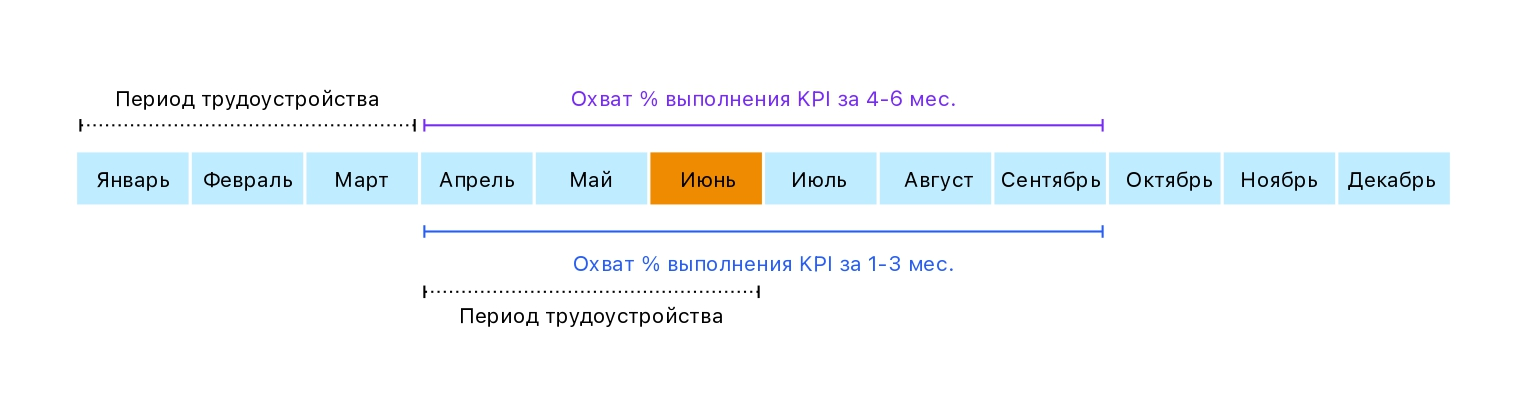

In [20]:
jan_2022 = pd.Timestamp('2022-01-01')
apr_2022 = pd.Timestamp('2022-04-01')
jun_2022 = pd.Timestamp('2022-06-01')
jul_2022 = pd.Timestamp('2022-07-01')

In [21]:
df_june_3 = df.loc[(df['Дата'] >= apr_2022) & (df['Дата'] < jun_2022)][['пп', 'Дата', '% выполнения KPI в первые 3 месяца работы']]
df_june_6 = df.loc[(df['Дата'] >= jan_2022) & (df['Дата'] < apr_2022)][['пп', 'Дата', '% выполнения KPI в 4-6 месяцы работы']]

In [22]:
df_june_6.head()

,пп,Дата,% выполнения KPI в 4-6 месяцы работы
5,6,2022-02-17,1.10
7,8,2022-03-29,1.56
17,18,2022-03-04,1.35
20,21,2022-03-15,NaN
38,39,2022-02-15,0.75


Переименуем столбцы с KPI:

In [23]:
df_june_3.rename({'% выполнения KPI в первые 3 месяца работы':'% KPI'}, axis='columns', inplace=True)
df_june_6.rename({'% выполнения KPI в 4-6 месяцы работы':'% KPI'}, axis='columns', inplace=True)

Объединяем выборки:

In [24]:
df_june = pd.concat([df_june_3, df_june_6])

print('Количество человек, работающих в июне 2022:', df_june.shape[0])

Количество человек, работающих в июне 2022: 566


Выделим лучших сотрудников, попадающих в верхний перцентиль. В качестве вернего возьмем значение 95%:

In [25]:
# находим значение квантиля и фильтруем
quant_95 = df_june['% KPI'].quantile(0.95)
df_june_best = df_june.loc[df_june['% KPI'] >= quant_95]

# сортируем лучших по убыванию
df_june_best = df_june_best.sort_values('% KPI', ascending=False)

# сохраняем список лучших работников
june_best_workers = df_june_best['пп'].to_list()

df_june_best

,пп,Дата,% KPI
814,815,2022-03-13,1.90
1335,1336,2022-03-16,1.90
940,941,2022-03-16,1.90
536,537,2022-04-05,1.90
538,539,2022-04-14,1.90
1648,1649,2022-04-06,1.87
857,858,2022-02-11,1.84
106,107,2022-05-13,1.77
1727,1728,2022-04-28,1.75
1687,1688,2022-04-04,1.75


Таких сотрудников оказалось 26 человек.

## Задание 2.1

**Проверьте, есть ли зависимость данных тестов с показателями продаж.**

Зависимость тестов от продаж можно проверить несколькими способами:
1. С помощью коррелиции. Соответственно если между тестом и % выполнения KPI есть ярко выраженная корреляция, то можно говорить о зависимости.
1. Разбив данные на 2 группы - работников с высоким KPI и с низким KPI. А далее сравнив их результаты тестов между собой. Соответственно если разница будет статистически значима, то данный тест имеет связь с продажами.

Построим матрицу коррелиции с тепловой картой:

In [ ]:
# Функция отрисовки тепловой карты для датасемпла
def plot_heatmap(correlations):
  plt.figure(figsize=(7, 7))
  sns.heatmap(correlations, cmap='coolwarm', annot=False, center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Корреляция'})
  plt.title('Корреляции переменных с KPI')
  plt.show()

In [ ]:
# Функция отрисовки тепловой карты для series
def plot_dual_heatmap(correlations1, correlations2, target1_name, target2_name, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # График для первого таргета
    sns.heatmap(correlations1.to_frame(), cmap='coolwarm', annot=True, center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Корреляция'}, ax=axes[0])
    axes[0].set_title(f'Корреляции переменных с продажами')

    # График для второго таргета
    sns.heatmap(correlations2.to_frame(), cmap='coolwarm', annot=True, center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Корреляция'}, ax=axes[1])
    axes[1].set_title(f'Корреляции переменных с продажами')

    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)

    plt.tight_layout()
    plt.show()

In [ ]:
target3 = '% выполнения KPI в первые 3 месяца работы'
target6 = '% выполнения KPI в 4-6 месяцы работы'

# сохранили тесты, зависимость которых будем анализировать
tests = scores[2:]

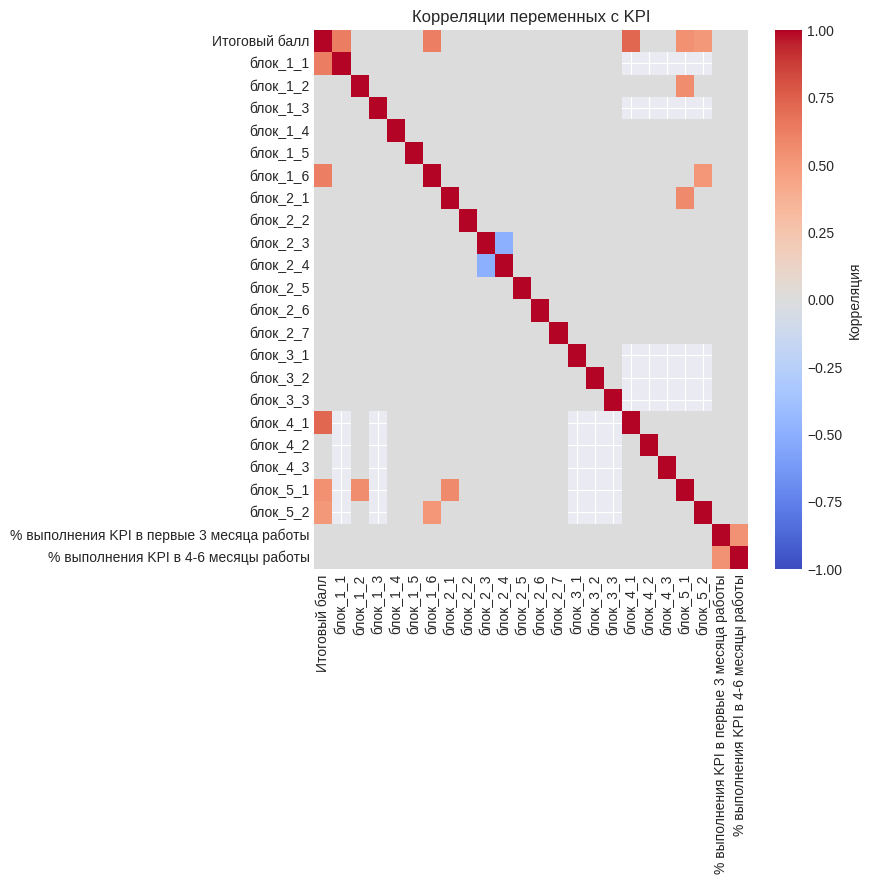

In [ ]:
correlations = df[tests + [target3, target6]].corr('spearman')

# для удобства анализа оставим на тепловой карте только коррелирующие фичи.
# В качестве границы корреляции возьмем либеральную 0.5
correlations = correlations.applymap(lambda x: 0 if abs(x) < 0.5 else x)

plot_heatmap(correlations)

Наблюдения:
- Некоторые тесты положительно коррелируют между собой
- Тест блока 2_4 отрицательно коррелирует с тестом блока 2_3. Интересно
- Корреляции тестов и результатов продаж не выявлено совсем
- Некоторые тесты взаимоисключаемы. Например, для тестов 1_1, 1_3 и всего блока 3, - полностью отсутствуют результаты тестов блоков 4 и 5.

*Построил еще матрицу по Пирсону. Идентичны.

**!ОФТОП**


---

*Создадим новую когорту: те, кто проходил тесты блоков 4-5 и тех, кто нет. Возможно это индикатор разных специальностей.*

In [ ]:
cols_to_check = ['блок_4_1', 'блок_4_2', 'блок_4_3', 'блок_5_1', 'блок_5_2']

df['cogorta_specialisation'] = df[cols_to_check].apply(lambda row: 'type1' if row.isna().all() else 'type2', axis=1)


In [ ]:
df['cogorta_specialisation'].value_counts()

type1    1502
type2     228
Name: cogorta_specialisation, dtype: int64

---

Посмотрим на матрицу рассеяния (добавить картинку)

Связи между баллами и KPI по всей выборке не выявлено. Посмотрим то же самое но в разрезе когорт

1502


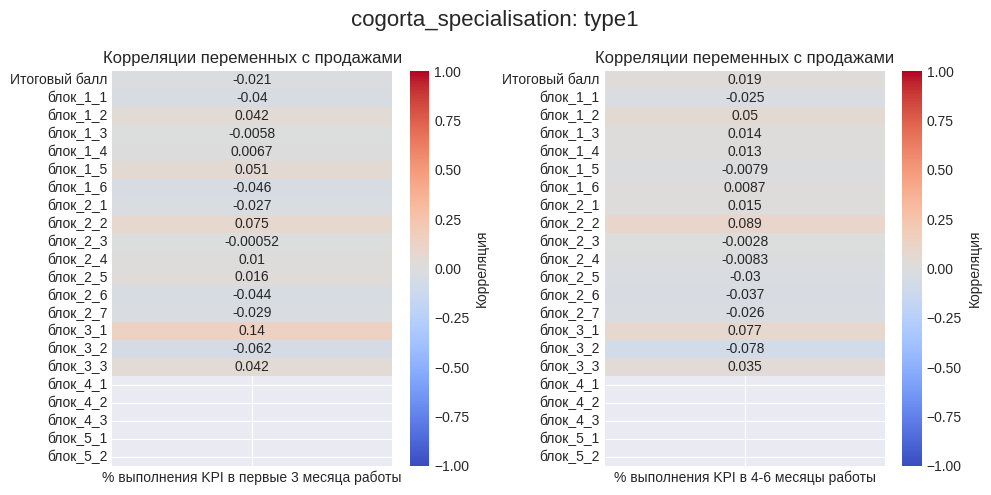

228


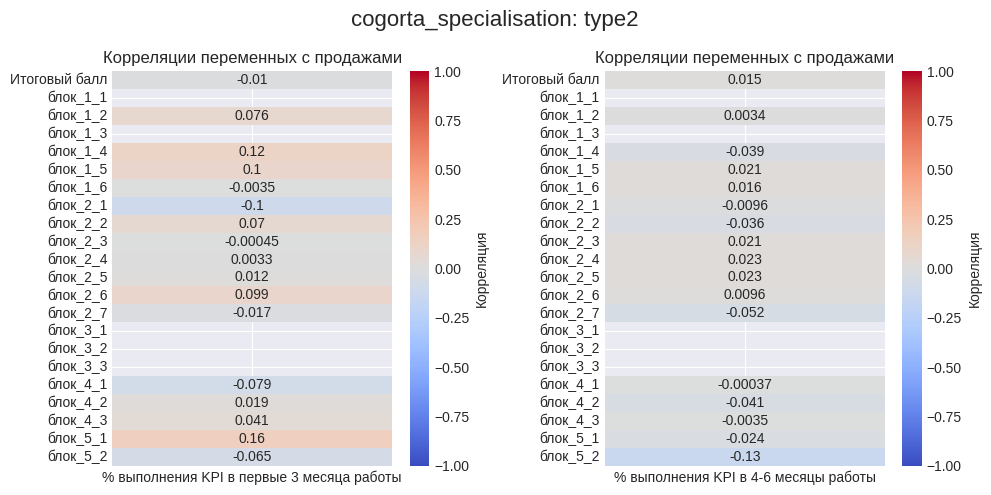

423


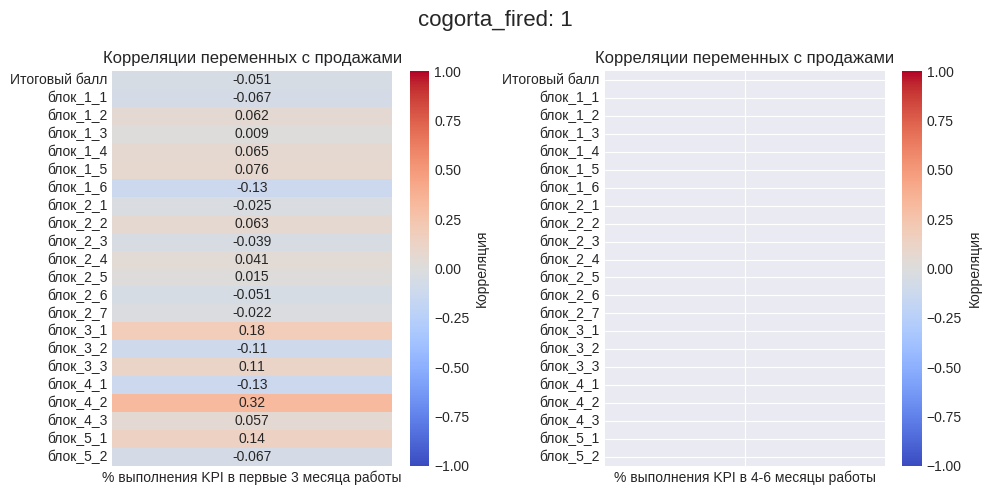

1307


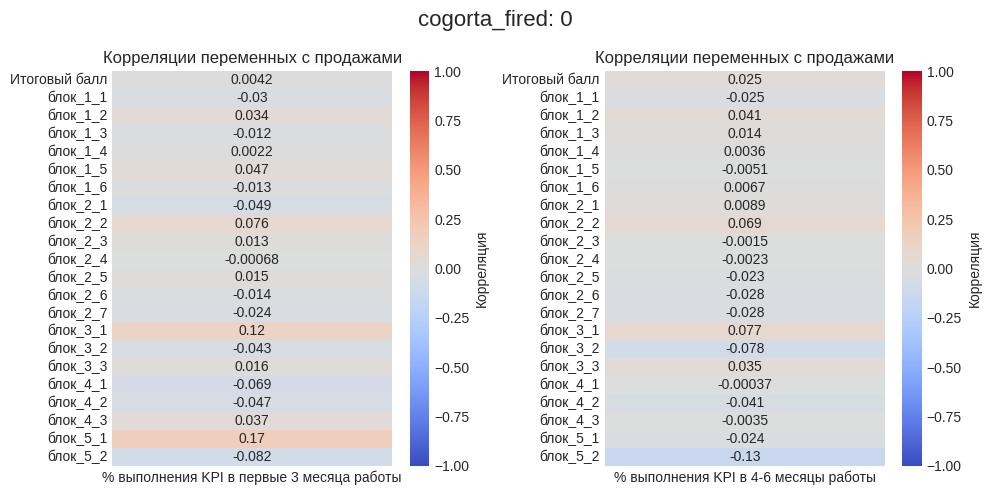

In [ ]:
dct_to_check = {'cogorta_specialisation':['type1', 'type2'],
                'cogorta_fired': [1, 0]}

target3 = '% выполнения KPI в первые 3 месяца работы'
target6 = '% выполнения KPI в 4-6 месяцы работы'

for cogorta, vals in dct_to_check.items():
  for val in vals:

    df_loc = df.loc[df[cogorta] == val]

    print(df_loc.shape[0])

    correlations3 = df_loc[tests + [target3]].corr()[target3].drop(target3)
    correlations6 = df_loc[tests + [target6]].corr()[target6].drop(target6)

    plot_dual_heatmap(correlations3,
                      correlations6,
                      target3,
                      target6,
                      title=f'{cogorta}: {val}')

В разбирке по когортам корреляции с продажами тоже не выявлено.

### Поиск стат. значимых различий

Так как значимых результатов при анализе корреляций мы не добились, попробуем найти связь с продажами разбив данные на группы. А далее сравнив группы между собой непараметрическим тестом.

В случае если уровень значимости будет ниже 5% можно утверждать что связь с % KPI есть.

Разделим работников на работников с высоким % KPI и с низким:

Количество наблюдений в группе Low: 864
Количество наблюдений в группе High: 865


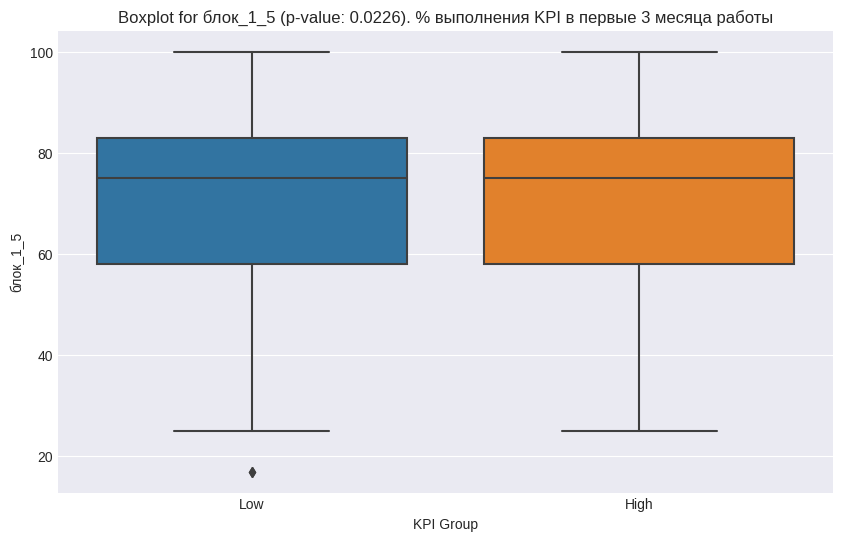

Количество наблюдений в группе Low: 864
Количество наблюдений в группе High: 865


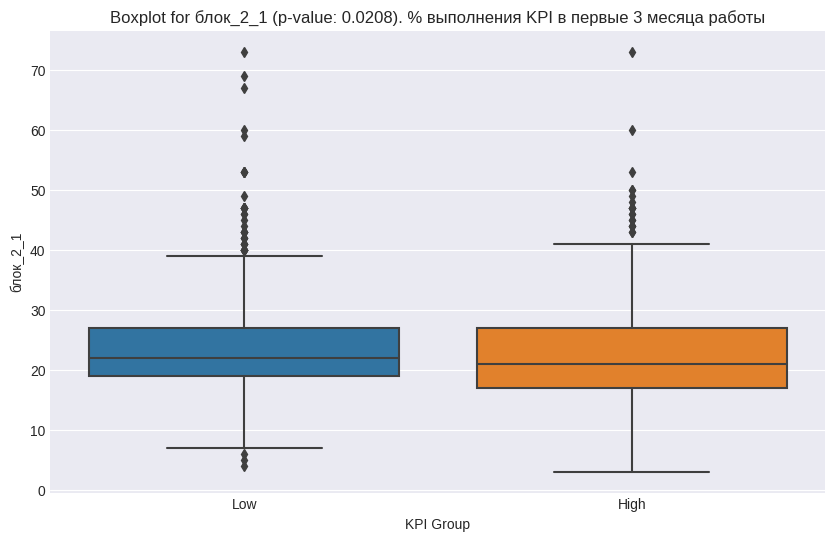

Количество наблюдений в группе Low: 735
Количество наблюдений в группе High: 767


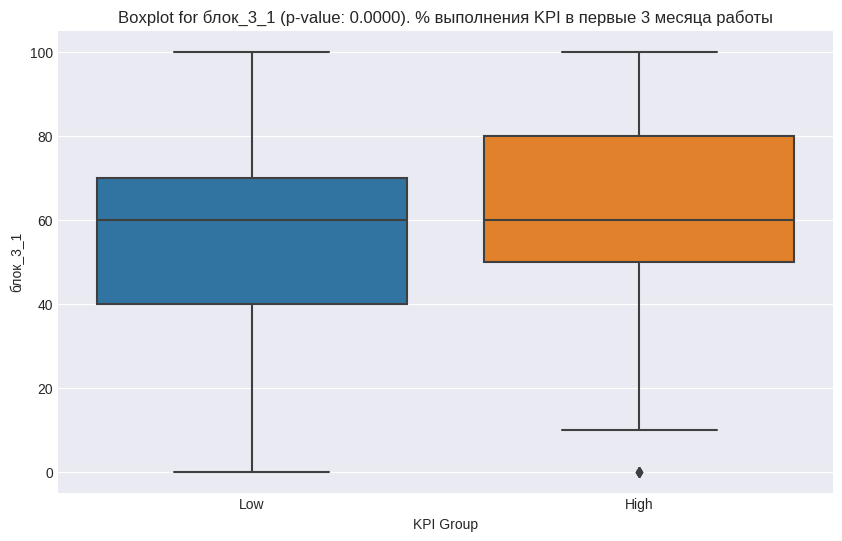

Количество наблюдений в группе Low: 735
Количество наблюдений в группе High: 767


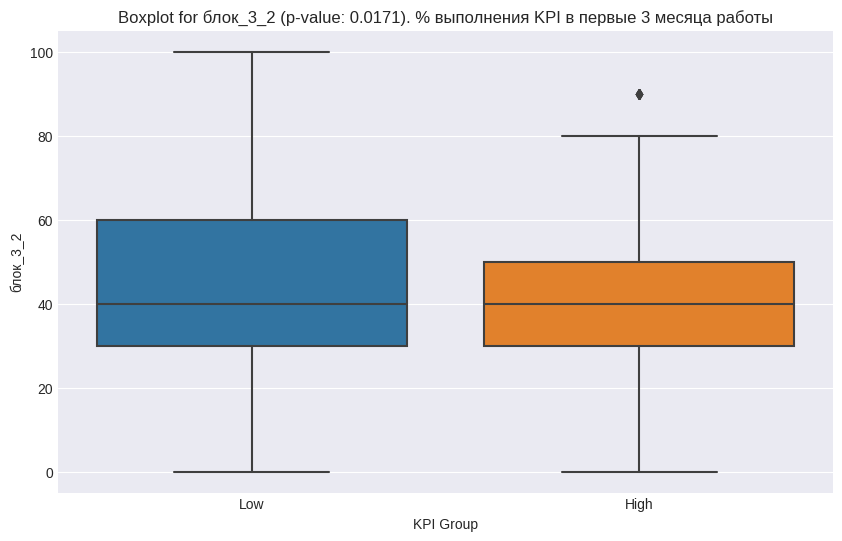

Количество наблюдений в группе Low: 485
Количество наблюдений в группе High: 563


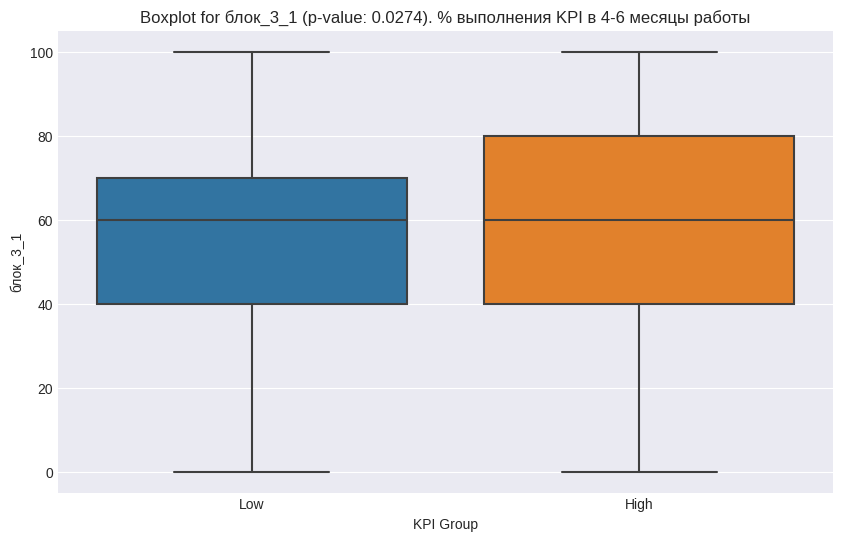

Количество наблюдений в группе Low: 485
Количество наблюдений в группе High: 563


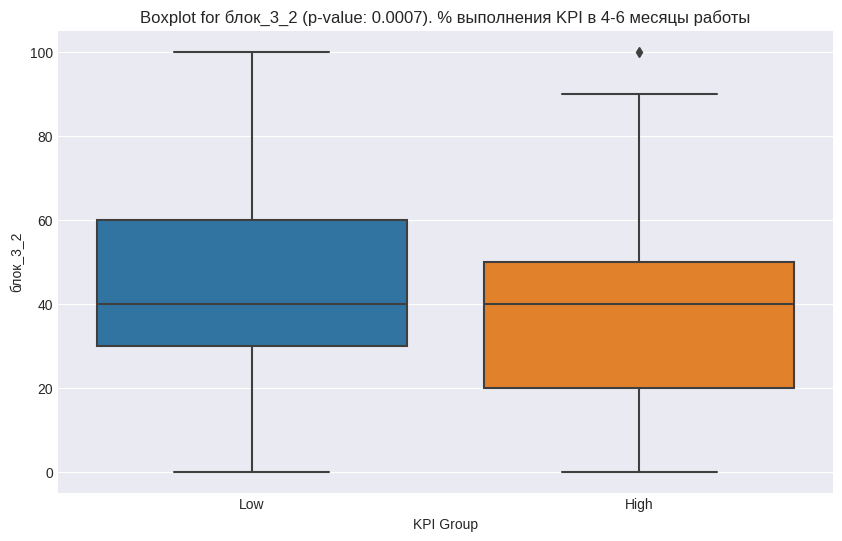

Тесты со статистически значимыми различиями: ['% выполнения KPI в первые 3 месяца работы: блок_1_5', '% выполнения KPI в первые 3 месяца работы: блок_2_1', '% выполнения KPI в первые 3 месяца работы: блок_3_1', '% выполнения KPI в первые 3 месяца работы: блок_3_2', '% выполнения KPI в 4-6 месяцы работы: блок_3_1', '% выполнения KPI в 4-6 месяцы работы: блок_3_2']


In [ ]:
significant_tests = []

for target in [target3, target6]:

  df_loc = df.copy()

  # Создание новой бинарной переменной на основе квантилей
  q50 = df_loc[target].quantile(0.5)

  min_val = df_loc[target].min()
  max_val = df_loc[target].max()

  df_loc['KPI_Group'] = pd.cut(df_loc[target], [min_val, q50, max_val], labels=['Low', 'High'])

  # Построение графиков и проверка на статистическую значимость
  for column in tests:
      # Тест Манна-Уитни
      group_low = df_loc[df_loc['KPI_Group'] == 'Low'][column].dropna()
      group_high = df_loc[df_loc['KPI_Group'] == 'High'][column].dropna()

      p_value = stats.mannwhitneyu(group_low, group_high).pvalue

      if p_value < 0.05:  # уровень значимости 0.05
          significant_tests.append(f'{target}: {column}')

          print('Количество наблюдений в группе Low:', group_low.shape[0])
          print('Количество наблюдений в группе High:', group_high.shape[0])

          plt.figure(figsize=(10, 6))
          sns.boxplot(data=df_loc, x='KPI_Group', y=column)
          plt.title(f'Boxplot for {column} (p-value: {p_value:.4f}). {target}')
          plt.ylabel(column)
          plt.xlabel('KPI Group')
          plt.show()

print("Тесты со статистически значимыми различиями:", significant_tests)

In [ ]:
for test in significant_tests:
  print(test)

% выполнения KPI в первые 3 месяца работы: блок_1_5
% выполнения KPI в первые 3 месяца работы: блок_2_1
% выполнения KPI в первые 3 месяца работы: блок_3_1
% выполнения KPI в первые 3 месяца работы: блок_3_2
% выполнения KPI в 4-6 месяцы работы: блок_3_1
% выполнения KPI в 4-6 месяцы работы: блок_3_2


**Вывод:**
Мы нашли стат. значимые различия в тестах между группами с высоким и низким KPI. Тесты блока 3_1, 3_2 являются значимыми как на промежутке в первые 3 месяца, так и на промежутке 3 последующих месяцев. Тесты блока 1_5, 2_1, показали значимость только на промежутке первых трех месяцев.

## Задание 2.2

**Если есть показатели, с которой не были обнаружены зависимости в п.1 – стоит ли от них сразу отказываться? Почему да или почему нет?**

Я читал про один эксперимент, где исследовалась внутреняя структура найма в стартапах. Суть: одни команды набирали себе исключительно крутых спецов, а другие - формировались их идейных людей с мощными софт скилами, кому нравилась сама идея. Через год около 50% стартапов с крутыми спецами разорились, при том что все 100% стартапов из людей с сильными софтами остались существовать.

Это я к тому, что KPI хороший инструмент для измерения пользы сотрудника, но далеко не единственный. Возвращаясь к тестам, да, некоторые из них могут быть связаны с будущим KPI сотрудника. В то время как другие, могут отражать его софтскилы. Пользу от них иногда сложно отобразить в цифрах. Поэтму я думаю что НЕ нужно сразу отказываться от других тестов. Но подвергнуть их анализу, с тем чтобы понять а что мы хотим измерить, и освободить сотрудников от очевидно бесполезных - однозначно стоит.

## Задание 2.3

**Какую пользу можно извлечь из этих данных? Как их можно использовать в процессе найма и в процессе жизненного цикла сотрудника.**

Например, найдем факторы, значимые для флага увольения.

Количество наблюдений в группе fired: 423
Количество наблюдений в группе worked: 1307


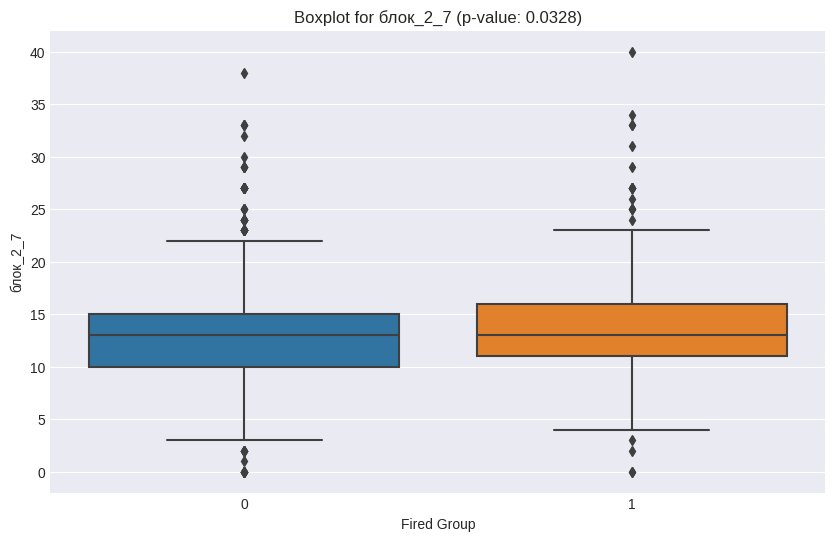

Количество наблюдений в группе fired: 391
Количество наблюдений в группе worked: 1111


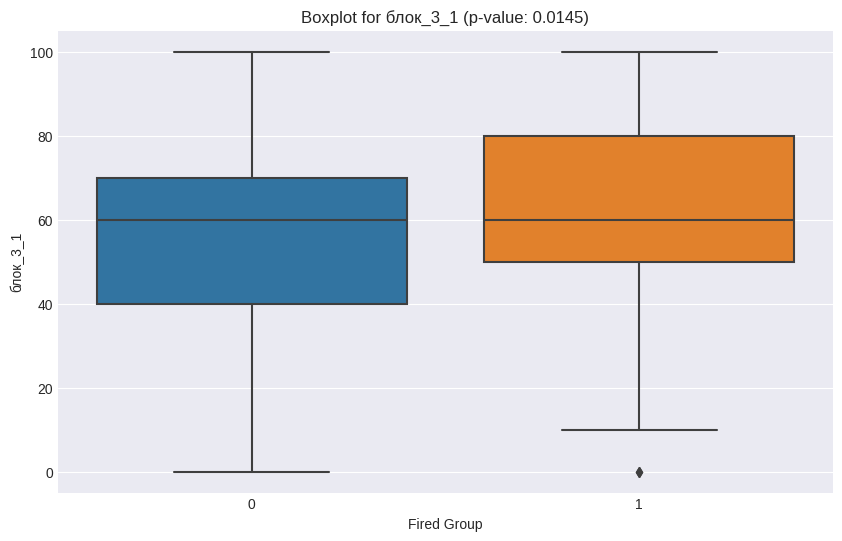

Тесты со статистически значимыми различиями: ['% выполнения KPI в 4-6 месяцы работы: блок_2_7', '% выполнения KPI в 4-6 месяцы работы: блок_3_1']


In [ ]:
significant_tests = []

# Построение графиков и проверка на статистическую значимость
for column in tests:
    # Тест Манна-Уитни
    group_fired = df[df['cogorta_fired'] == 1][column].dropna()
    group_worked = df[df['cogorta_fired'] == 0][column].dropna()

    p_value = stats.mannwhitneyu(group_fired, group_worked).pvalue

    if p_value < 0.05:  # уровень значимости 0.05
        significant_tests.append(f'{target}: {column}')

        print('Количество наблюдений в группе fired:', group_fired.shape[0])
        print('Количество наблюдений в группе worked:', group_worked.shape[0])

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='cogorta_fired', y=column)
        plt.title(f'Boxplot for {column} (p-value: {p_value:.4f})')
        plt.ylabel(column)
        plt.xlabel('Fired Group')
        plt.show()

print("Тесты со статистически значимыми различиями:", significant_tests)

Результаты тестов "блок_2_7" и "блок_3_1" значимо различаются между группой "потенциально уволятся к 4 месяцу" и группой "прорабоатет 6 месяцев и больше".

На основании этих данных мы можем сформировать стоп-факторы, которые были бы индикаторами потенциальной ненадежности сотрудника. Это могло бы помочь на ранней стадии принять меры по сохранению сотрудника, либо попрощаться с ним.

Помимо этого, мы нашли стат. значимые факторы которые влияют на % выполнения KPI. Эти факторы могли бы помочь сфо

In [ ]:
,for test in significant_tests:
  print(test)

% выполнения KPI в 4-6 месяцы работы: блок_2_7
% выполнения KPI в 4-6 месяцы работы: блок_3_1


 ## Задание 2.4

**Какие могут быть «подводные камни» при внедрении тестов в процесс?**

На самом деле тестирование может иметь множество подводных камней. Начнем с проблемами самих тестов.
1. Тесты, которые бы достоверно отражали профиль кандидата разработать достаточно сложно. Просто потому, что и кандидаты бывают разные, и количество потенциальных скиллов для теста очень велико.
2. Актуальность. В современном мире информация быстро устаревает, как и скиллы. Поэтому актуальность тестов нужно постоянно поддерживать. Отсюда вытекает следующая проблема.
3. Штат сотрудников для поддержания актуальности тестов. Для проведения качественного тестирования, такого, которое бы многогранно отражало портрет кандидата, требуются большие усилия. Для этого нужны хорошие высокооплачиваемые специалисты, что может быть дорого для компании.
4. Принцип бритвы Оккама. Тесты должны быть полезными. Своей главной задачей они должны иметь поддержание прибыли компании. Поэтому, затраты на тестирование должны быть ниже чем потенциальная от них прибыль. Это тоже требует разработки решения оценки качества тестирования и его потенциальной пользы.

Сотрудники

5. Помимо подводных камней с тестами есть еще большой блок опасностей при раскатке их на кандидатов. Тестирование, особенно объемное, может отпугивать некоторых из них, что грозит потерей кадров.
6. Тесты отнимают полезное время, деньги и нервы. Время, которое могло быть потрачено на генерацию пользы для компании уходит на тестирование, тем самым увеличивая упущеную прибыль.
7. Некоторые сотрудники могут хитрить, чем будут завышать свои результаты, что снижает качество тестирования. Это подводит нас к следующему тезису.
8. Интерпретация и применение результатов. Слишком большой упор на тестирование может снижать качество человеческого капитала в компании из-за приведенного выше риска.

В целом, всего должно быть в меру. Тестирование может быть хорошим инструментом, но лишь одним из. Сотрудник - это в первую очередь человек. Сложное существо, зависящее от громадного множества факторов окружающей среды. Поэтому для его оценки как потенциальной части компании нужно прибегать к разным, независящим друг от друга инструментам.


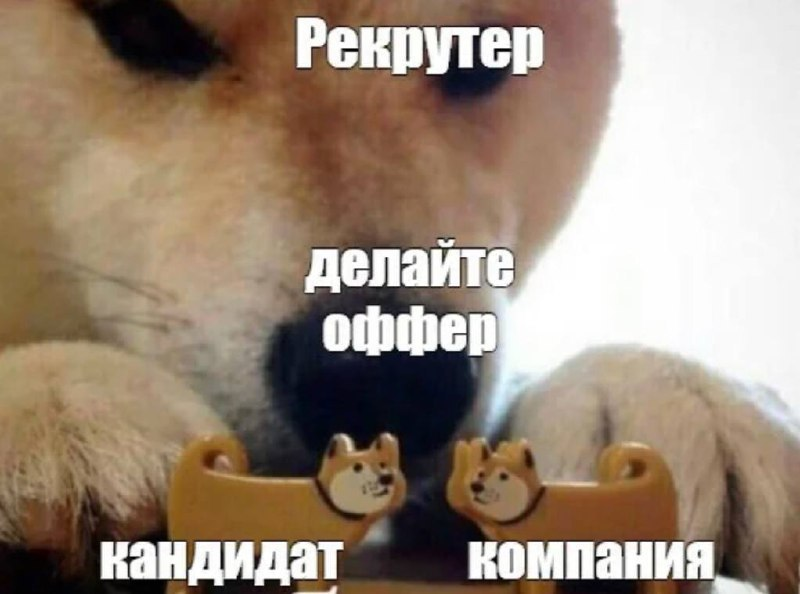